In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#Download dataset
#### !curl https://raw.githubusercontent.com/francescopisu/Used-car-price-prediction/master/data/cars.csv --output cars.csv

In [3]:
#import pyspark
#Check below link for alternative
#https://goodboychan.github.io/python/datacamp/pyspark/machine_learning/2020/08/10/01-Model-tuning-and-selection-in-PySpark.html#Make-the-validator

### Importing libraries

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib
import pickle
import matplotlib.pyplot as plt
#import curves
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#from spark_sklearn.util import createLocalSparkSession
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [3]:
cars= pd.read_csv("cars.csv", encoding="latin1", error_bad_lines= False, warn_bad_lines= False)

In [4]:
cars.sample(5)

,Id,Price,Year,Mileage,City,State,Vin,Make,Model
82113,82114,12599,2016,21640,Salt Lake City,UT,1C3CDFFAXGD821070,Dodge,DartSXT
277215,277216,9997,2015,32779,Bellevue,WA,1N4AZ0CP6FC326305,Nissan,LEAFS
845165,850532,13994,2016,30419,Scottsdale,AZ,1C4NJCBAXGD621761,Jeep,CompassSport
101700,101701,18990,2009,158368,Pikeville,KY,3GCEK23349G158450,Chevrolet,Silverado
172018,172019,19499,2014,20380,Orlando,FL,WBA3B5C55EF959231,BMW,3


In [5]:
cars.columns

Index(['Id', 'Price', 'Year', 'Mileage', 'City', 'State', 'Vin', 'Make',
       'Model'],
      dtype='object')

In [6]:
cars.shape

(1216250, 9)

### Analyzing price attributes

In [7]:
cars["Price"].describe()

count    1.216250e+06
mean     2.096887e+04
std      1.315940e+04
min      1.500000e+03
25%      1.299400e+04
50%      1.799500e+04
75%      2.641400e+04
max      4.995000e+05
Name: Price, dtype: float64

Skewness: 4.974661
Kurtosis: 80.585280


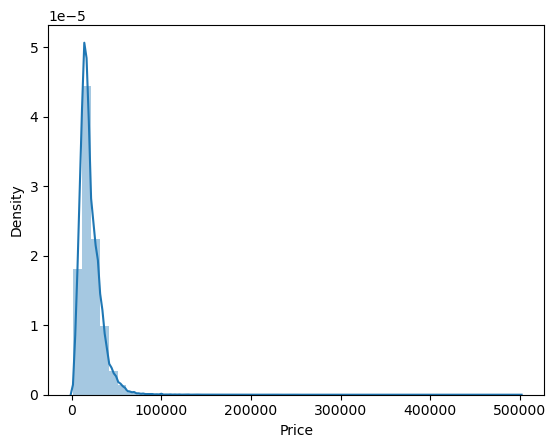

In [8]:
sns.distplot(cars["Price"])

#skewness and kurtosis
print("Skewness: %f" % cars["Price"].skew())
print("Kurtosis: %f" % cars["Price"].kurt())

"""
We can observe that the distribution of prices shows a high positive skewness to the left (skew>1).
A kurtosis value of 80 is extremely high, meaning that there is a profusion of outliers in the dataset. 
We need to do something
"""

## Relationship with numerical features

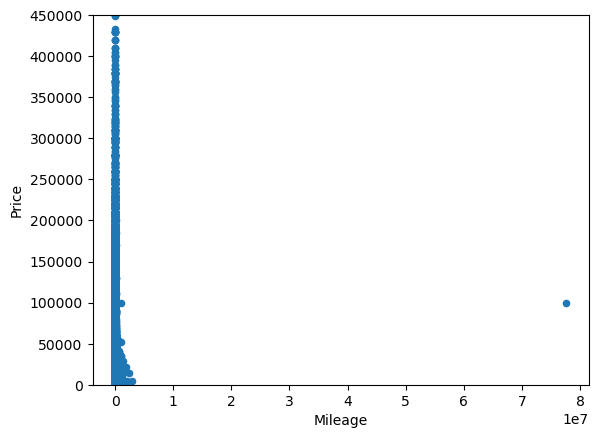

In [9]:
#Scatter plot ofr Mileage/ Price
attrib= "Mileage"
data= pd.concat([cars["Price"], cars[attrib]], axis=1)
data.plot.scatter(x= attrib, y="Price", ylim=(0,450000));


"""
It's actually like an exponential decay once we remove the outlierbeyond 7*1e7 Mileage outlier
"""

In [10]:
cars[cars["Mileage"]>5000000]

,Id,Price,Year,Mileage,City,State,Vin,Make,Model
991642,997010,98995,2017,77587763,White Plains,NY,WDDUG8FB7HA296392,Mercedes-Benz,S-ClassS


In [11]:
cars.drop(index=991642, axis=0, inplace=True)

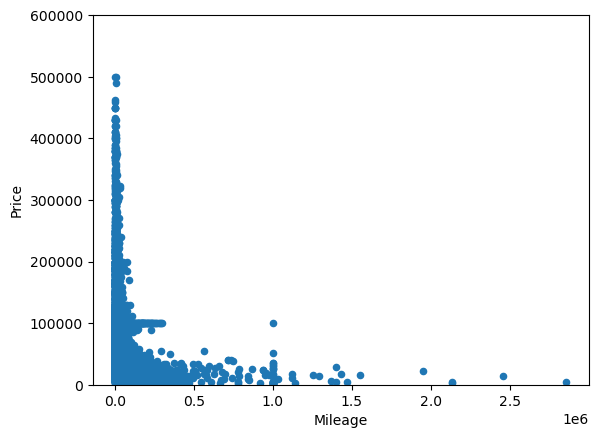

In [14]:
#Scatter plot ofr Mileage/ Price
attrib= "Mileage"
data= pd.concat([cars["Price"], cars[attrib]], axis=1)
data.plot.scatter(x= attrib, y="Price", ylim=(0,600000));

"""
We seee that the lesser the mileage, the higher tends to be the price.
Price and Mileage seems to be in exponential relationship with negative exponent,
It;s a typical form of exponential decay
"""


In [15]:
cars.shape

(1216249, 9)

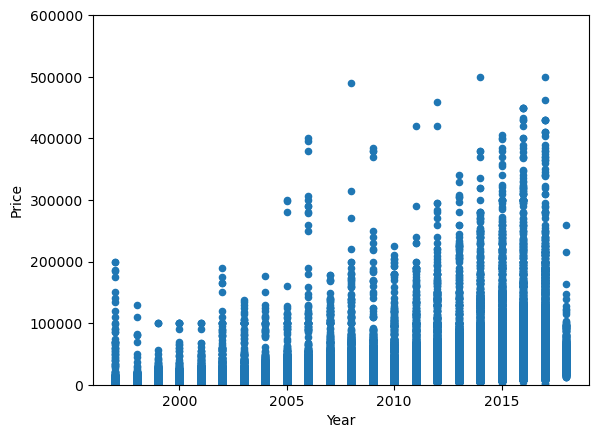

In [18]:
#Scatter plut Year/Price
attrib="Year"

data= pd.concat([cars["Price"], cars[attrib]], axis=1)
data.plot.scatter(x=attrib, y= "Price", ylim=(0,600000));



"""
Prices tend to be higher as cars are moree recent , and viceversa
"""

### Relationship with categorical features

'\nWe can observe there is a correlation between Price and Exotic/Luxury car manufacturers.\nThere is presence of low to medium budget cards in the dataset\n\nSeveral car manufacturers as Ferrari, lamborghini, Rolls Royce etc..have a strong presence of outliers, although \noutliers may not be the right term because those makers actuall procduce cars that cost more than others\n'

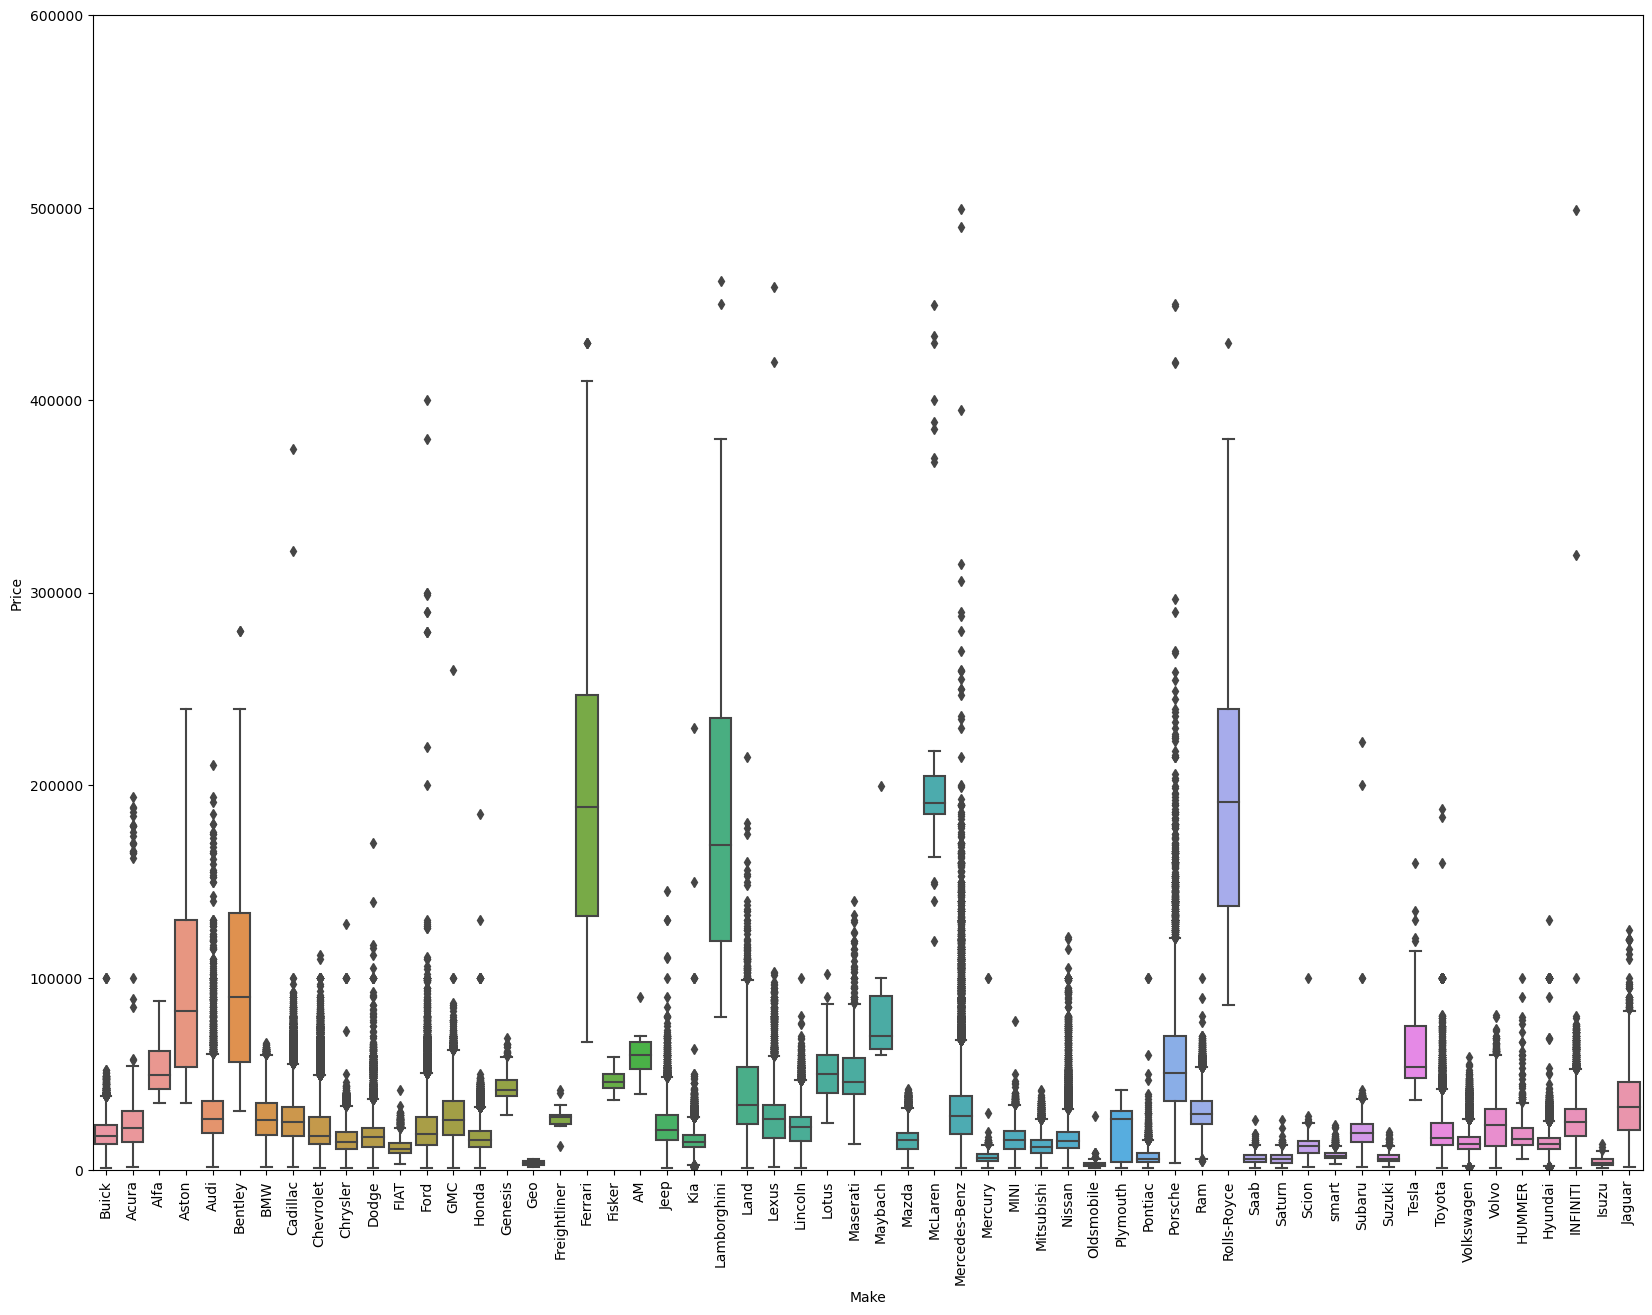

In [23]:
# Box plot Make(Car Manufacturers)/ prices
attrib= "Make"
data= pd.concat([cars["Price"], cars[attrib]], axis=1)
f, ax= plt.subplots(figsize=(20,15))
fig= sns.boxplot(x=attrib, y="Price", data= data)
fig.axis(ymin=0, ymax=600000)
plt.xticks(rotation=90);

"""
We can observe there is a correlation between Price and Exotic/Luxury car manufacturers.
There is presence of low to medium budget cards in the dataset

Several car manufacturers as Ferrari, lamborghini, Rolls Royce etc..have a strong presence of outliers, although 
outliers may not be the right term because those makers actuall procduce cars that cost more than others
"""

'\nWe can observe a slight increase of Prices in the most recent years. not a strong tendency though\n'

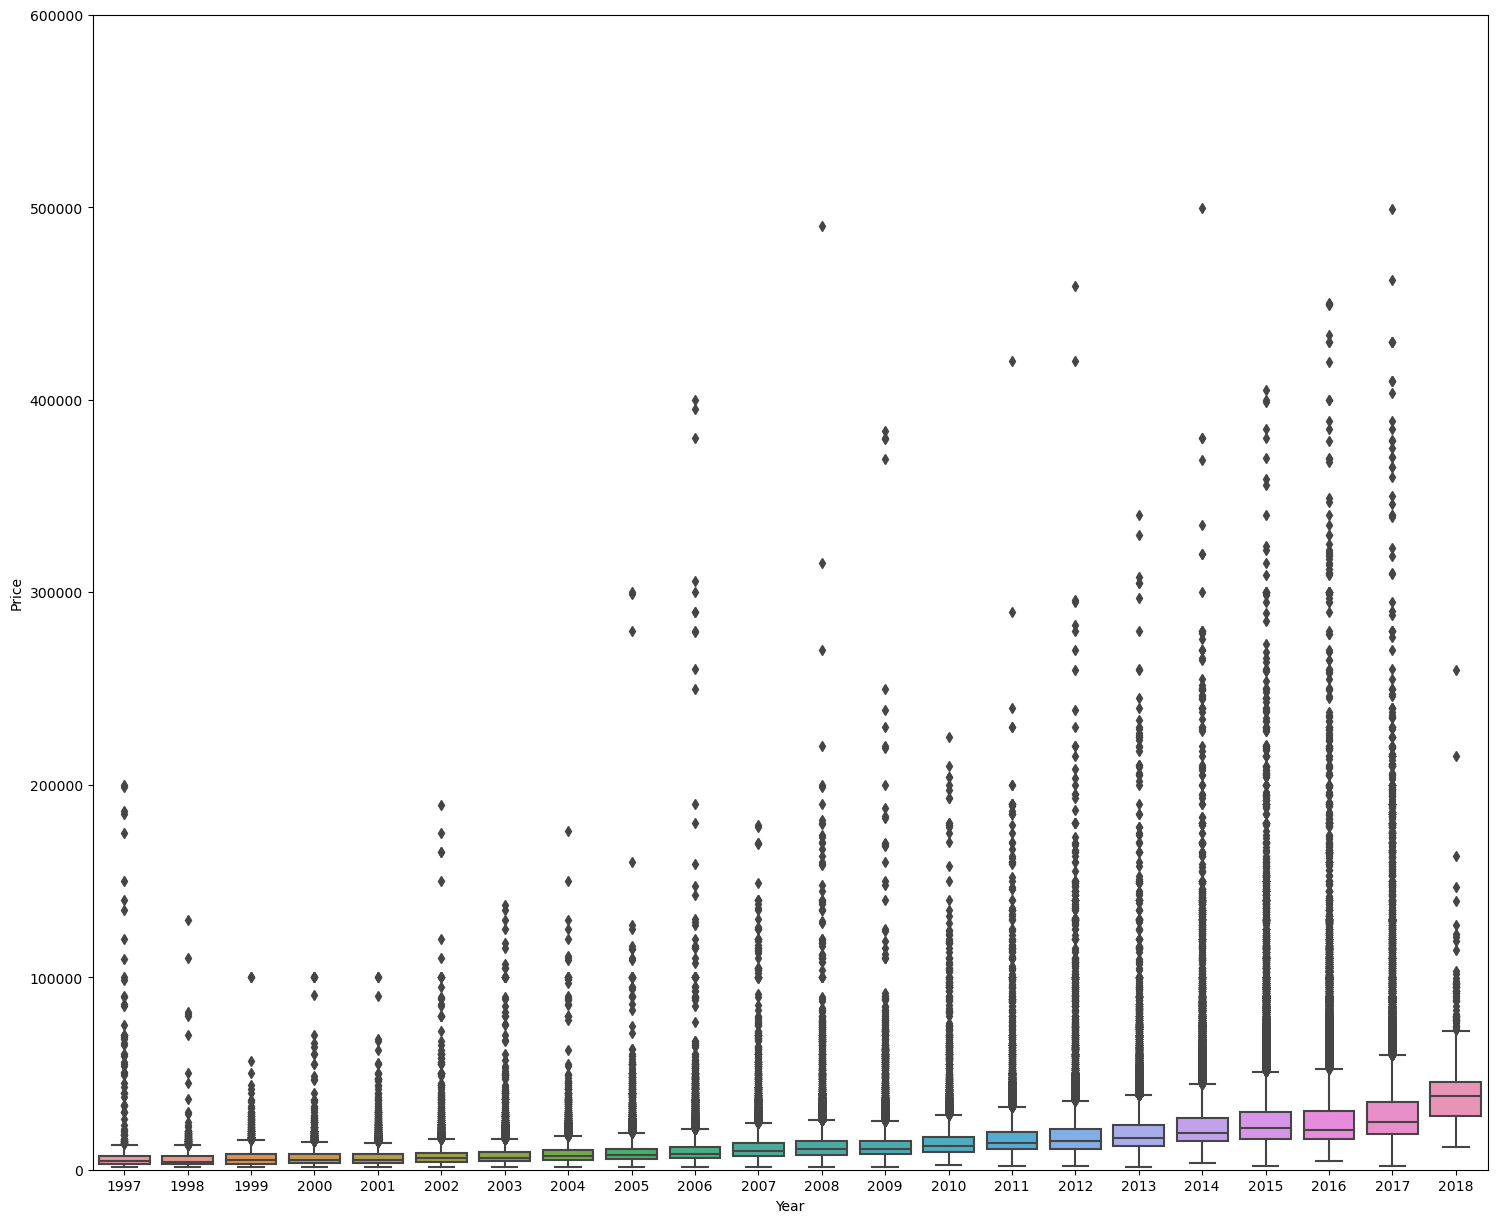

In [25]:
#Box plot Year/ Price

attrib="Year"
data= pd.concat([cars["Price"], cars[attrib]], axis=1)
f,ax= plt.subplots(figsize=(18,15))
fig= sns.boxplot(x=attrib, y="Price", data= data)
fig.axis(ymin=0, ymax=600000);

"""
We can observe a slight increase of Prices in the most recent years. not a strong tendency though
"""


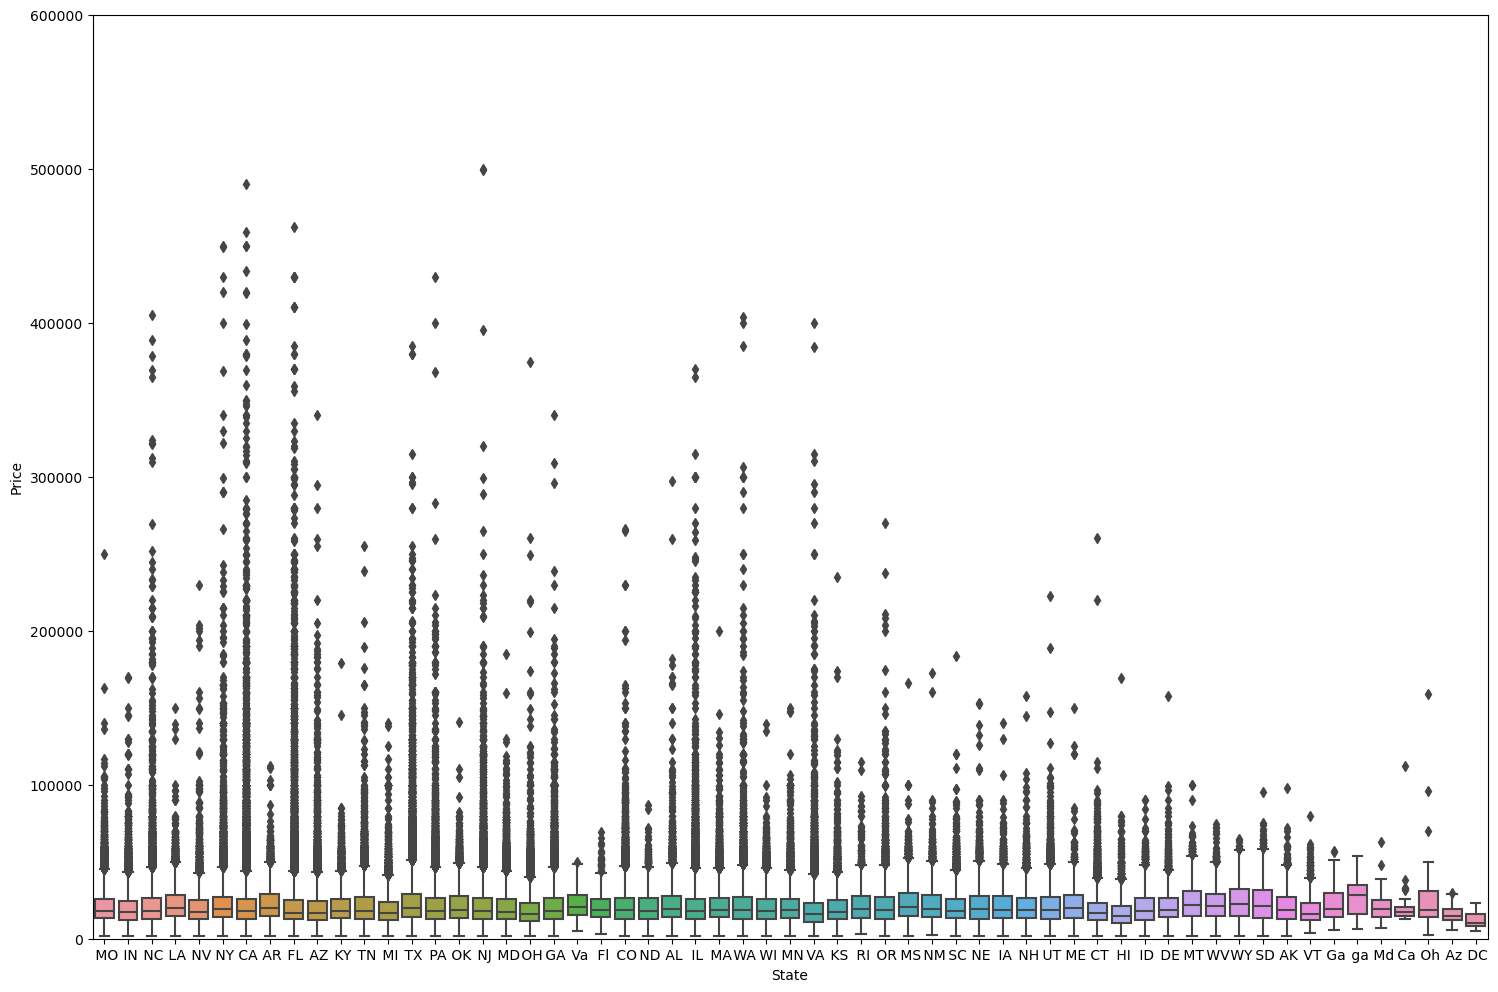

In [27]:
# Box plot state/ Price

attrib= "State"
data= pd.concat([cars["Price"], cars[attrib]], axis=1)
f,ax= plt.subplots(figsize=(18, 12))
fig= sns.boxplot(x= attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=600000);

### Feature impostance related to target

In [28]:
#find most iportant features relative to target Price
print("Find most important features relative to target")
corr= cars.corr()
corr.sort_values(["Price"], ascending= False, inplace=True)
print(corr.Price)

"""
Between Year and price there is a positive correlation, meaning that the higher is the year(more recent), 
the higher is the Price (more recent cars cost more). Between Price and Mileage there is a negative correlation, 
meaning that higher is the mileage, lowet is the Price (cars with high mileage cost less).

We will get rid of id attributes.
"""

Find most important features relative to target
Price      1.000000
Year       0.405674
Id        -0.013845
Mileage   -0.422759
Name: Price, dtype: float64


'\nBetween Year and price there is a positive correlation, meaning that the higher is the year(more recent), \nthe higher is the Price (more recent cars cost more). Between Price and Mileage there is a negative correlation, \nmeaning that higher is the mileage, lowet is the Price (cars with high mileage cost less).\n\nWe will get rid of id attributes.\n'

### Correlation matrix

'\nThere is a mild positive corerlation between Year and Price and Price and a mild\nnegative correlation between Year and Mileage (as we have already said).Moreover there is a strong negative \ncorrelation between Mileage and Year;\nmeaning that the older is the car, the higher will be its mileage.\nObviously there are exceptions but that is the general trend.\n'

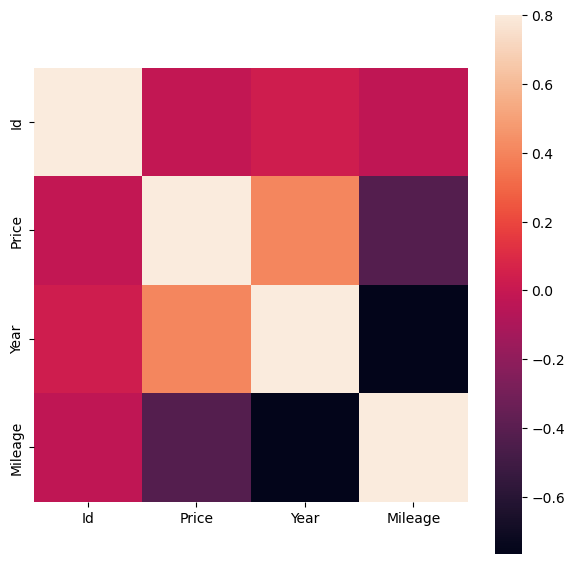

In [31]:
# General correlation matrix
corrmat= cars.corr()
f,ax= plt.subplots(figsize=(7,7))
sns.heatmap(corrmat, vmax=.8, square=True);


"""
There is a mild positive corerlation between Year and Price and Price and a mild
negative correlation between Year and Mileage (as we have already said).Moreover there is a strong negative 
correlation between Mileage and Year;
meaning that the older is the car, the higher will be its mileage.
Obviously there are exceptions but that is the general trend.
"""


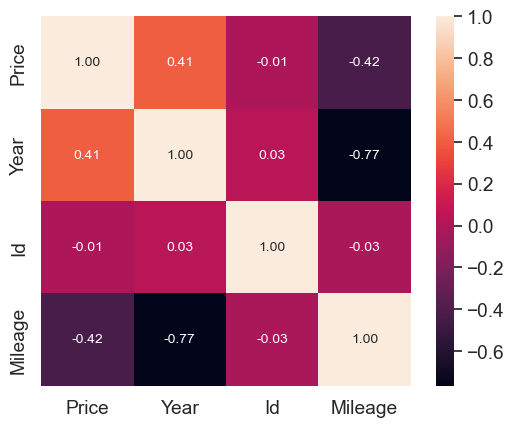

'\nThis plot shows what we said earlier in the form of numbers\n'

In [40]:
#Price correlation matrix
k=4 # number of variables for heatmap
cols= corrmat.nlargest(k,"Price")["Price"].index
cm= np.corrcoef(cars[cols].values.T)

sns.set(font_scale=1.25)
hm= sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={'size':10}, yticklabels= cols.values,
               xticklabels= cols.values)

plt.show()

"""
This plot shows what we said earlier in the form of numbers
"""


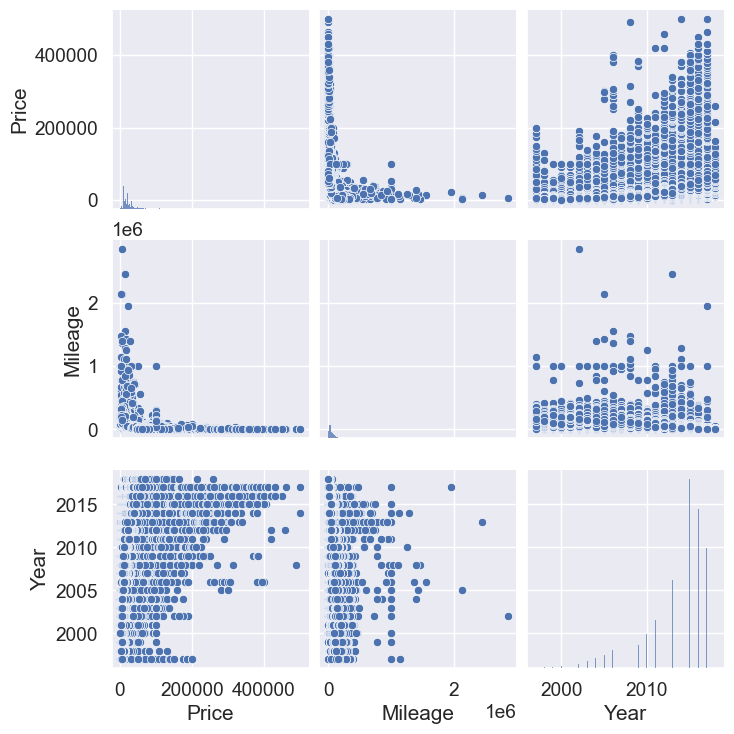

In [47]:
### ScatterPlots for numerical features
num_features= ["Price", "Mileage", "Year"]
sns.pairplot(cars[num_features], size=2.5);
plt.show()

### Preprocessing

In [48]:
#Checking for missing values
cars.isnull().sum()

Id         0
Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

In [50]:
#Running describe function to make initial observations

cars.describe()

,Id,Price,Year,Mileage
count,1.216249e+06,1.216249e+06,1.216249e+06,1.216249e+06
mean,6.132811e+05,2.096881e+04,2.013307e+03,5.284435e+04
std,3.546571e+05,1.315922e+04,3.441842e+00,4.206390e+04
min,1.000000e+00,1.500000e+03,1.997000e+03,5.000000e+00
25%,3.081120e+05,1.299400e+04,2.012000e+03,2.396200e+04
50%,6.134910e+05,1.799500e+04,2.014000e+03,4.053400e+04
75%,9.175530e+05,2.641400e+04,2.016000e+03,7.272500e+04
max,1.233042e+06,4.995000e+05,2.018000e+03,2.856196e+06


#Record distribution over the year
sns.distplot(cars["Year"])

In [53]:
#Checking values of categorical features
cat_val=["City", "State","Vin","Make","Model"]
for col in cat_val:
    print([col]," : ", cars[col].unique())
    
    

['City']  :  ['Jefferson City' 'Highland' 'Boone' ... 'Northfield' 'Huntington Valley'
 'Winslow']
['State']  :  [' MO' ' IN' ' NC' ' LA' ' NV' ' NY' ' CA' ' AR' ' FL' ' AZ' ' KY' ' TN'
 ' MI' ' TX' ' PA' ' OK' ' NJ' ' MD' ' OH' ' GA' ' Va' ' Fl' ' CO' ' ND'
 ' AL' ' IL' ' MA' ' WA' ' WI' ' MN' ' VA' ' KS' ' RI' ' OR' ' MS' ' NM'
 ' SC' ' NE' ' IA' ' NH' ' UT' ' ME' ' CT' ' HI' ' ID' ' DE' ' MT' ' WV'
 ' WY' ' SD' ' AK' ' VT' ' Ga' ' ga' ' Md' ' Ca' ' Oh' ' Az' ' DC']
['Vin']  :  ['KL4CJBSBXFB267643' 'KL4CJASB5FB245057' 'KL4CJCSB0FB264921' ...
 'YV4A22PL4J1212676' 'YV4A22PL3H1186162' 'YV4A22NLXH1006162']
['Make']  :  ['Buick' 'Acura' 'Alfa' 'Aston' 'Audi' 'Bentley' 'BMW' 'Cadillac'
 'Chevrolet' 'Chrysler' 'Dodge' 'FIAT' 'Ford' 'GMC' 'Honda' 'Genesis'
 'Geo' 'Freightliner' 'Ferrari' 'Fisker' 'AM' 'Jeep' 'Kia' 'Lamborghini'
 'Land' 'Lexus' 'Lincoln' 'Lotus' 'Maserati' 'Maybach' 'Mazda' 'McLaren'
 'Mercedes-Benz' 'Mercury' 'MINI' 'Mitsubishi' 'Nissan' 'Oldsmobile'
 'Plymouth' 'Pontiac' 'P

In [55]:
# Features like state, Id, Vin can be discarded because they wouldn't bring anything good to our purpose

### Outliers Management

#### Bivariate Analysis

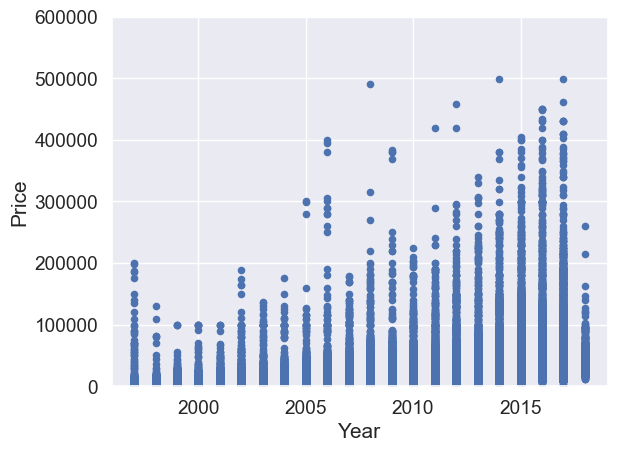

In [56]:
# Bivariate analysis Price/Year

attrib= "Year"
data= pd.concat([cars["Price"], cars[attrib]], axis=1)
data.plot.scatter(x= attrib, y="Price", ylim=(0, 600000));

#### Removing outliers by model

In [77]:
grouped_df=cars.groupby(["Make","Model"])["Price"].mean().reset_index()
grouped_df

,Make,Model,Price
0,AM,General,59934.210526
1,Acura,CLAutomatic,4492.666667
2,Acura,CLManual,4493.000000
3,Acura,CLType-S,5207.736842
4,Acura,ILX4dr,15490.000000
...,...,...,...
3119,smart,fortwoProxy,18284.000000
3120,smart,fortwoPure,13580.142857
3121,smart,fortwopassion,7766.910714
3122,smart,fortwoprime,16210.250000


In [78]:
grouped_df.rename(columns={"Price":"Mean Price"}, inplace=True)
grouped_df


,Make,Model,Mean Price
0,AM,General,59934.210526
1,Acura,CLAutomatic,4492.666667
2,Acura,CLManual,4493.000000
3,Acura,CLType-S,5207.736842
4,Acura,ILX4dr,15490.000000
...,...,...,...
3119,smart,fortwoProxy,18284.000000
3120,smart,fortwoPure,13580.142857
3121,smart,fortwopassion,7766.910714
3122,smart,fortwoprime,16210.250000


In [84]:
grouped_df[grouped_df["Mean Price"]>100000]["Make"].unique()

array(['Acura', 'Audi', 'Bentley', 'Dodge', 'Ferrari', 'Ford', 'Jaguar',
       'Lamborghini', 'Lexus', 'Maybach', 'McLaren', 'Mercedes-Benz',
       'Porsche', 'Rolls-Royce'], dtype=object)

In [86]:
MeanPrice_Make=grouped_df.groupby(["Make"])["Mean Price"].mean().reset_index()

In [87]:
MeanPrice_Make.head()

,Make,Mean Price
0,AM,59934.210526
1,Acura,21888.907325
2,Alfa,54228.704545
3,Aston,99573.617450
4,Audi,40051.353650


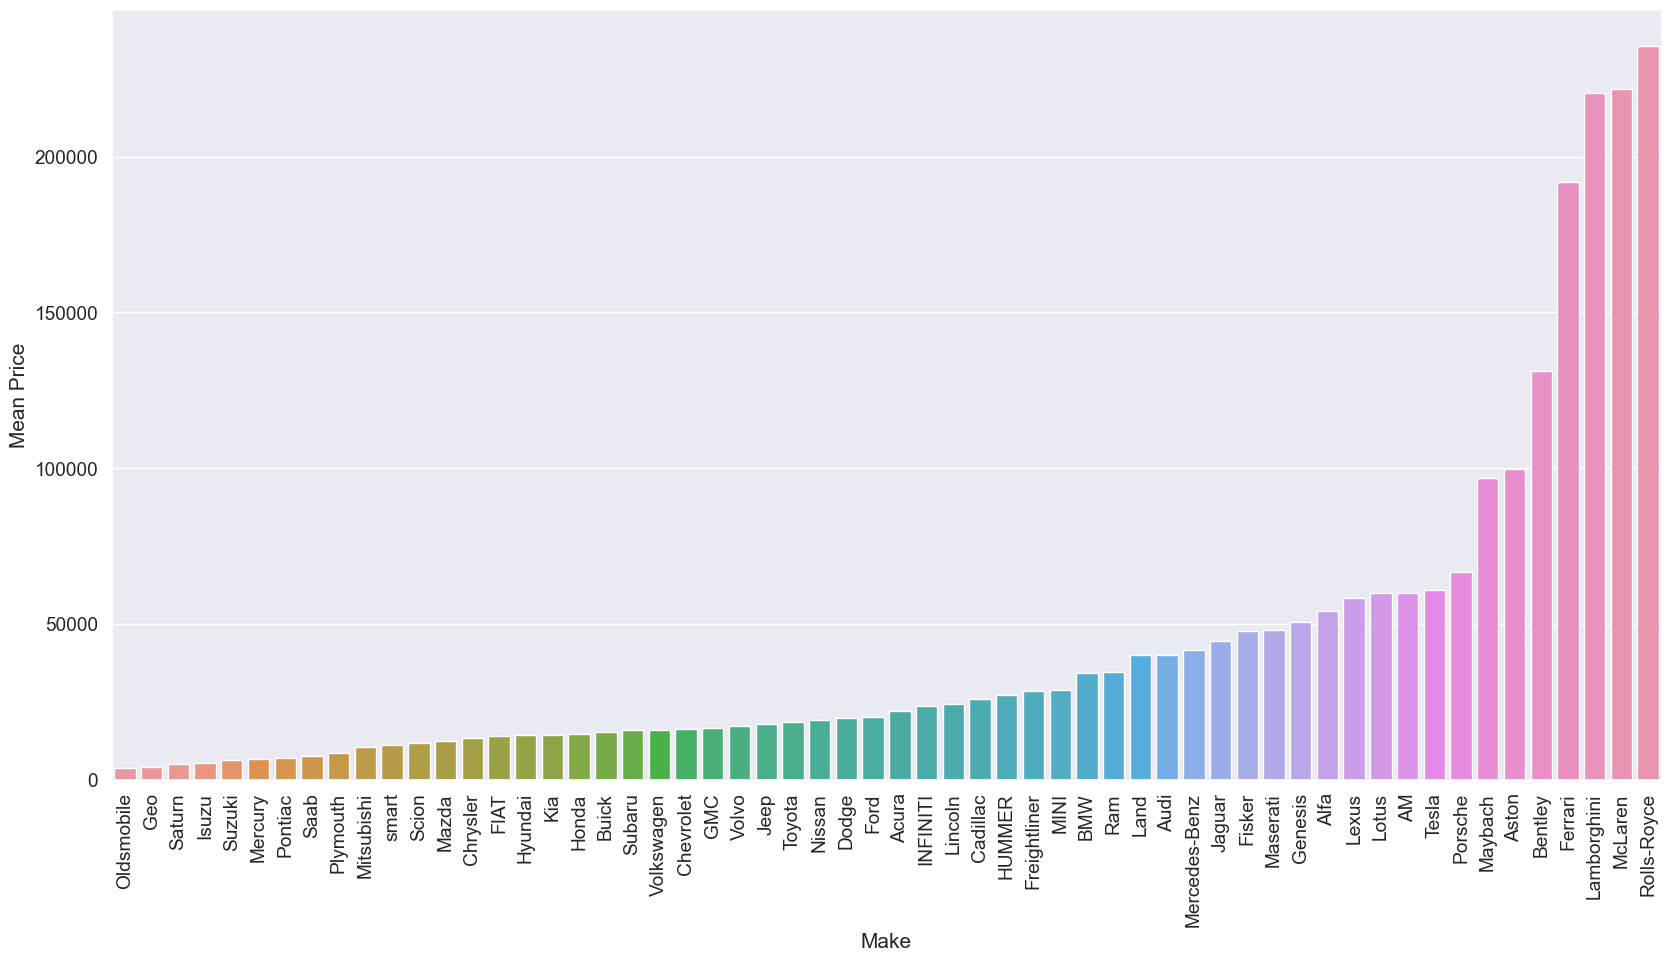

In [95]:
f,ax=plt.subplots(figsize=(20,10))
fig=sns.barplot(x="Make", y="Mean Price", data=MeanPrice_Make.sort_values(by=["Mean Price"]));
plt.xticks(rotation=90);

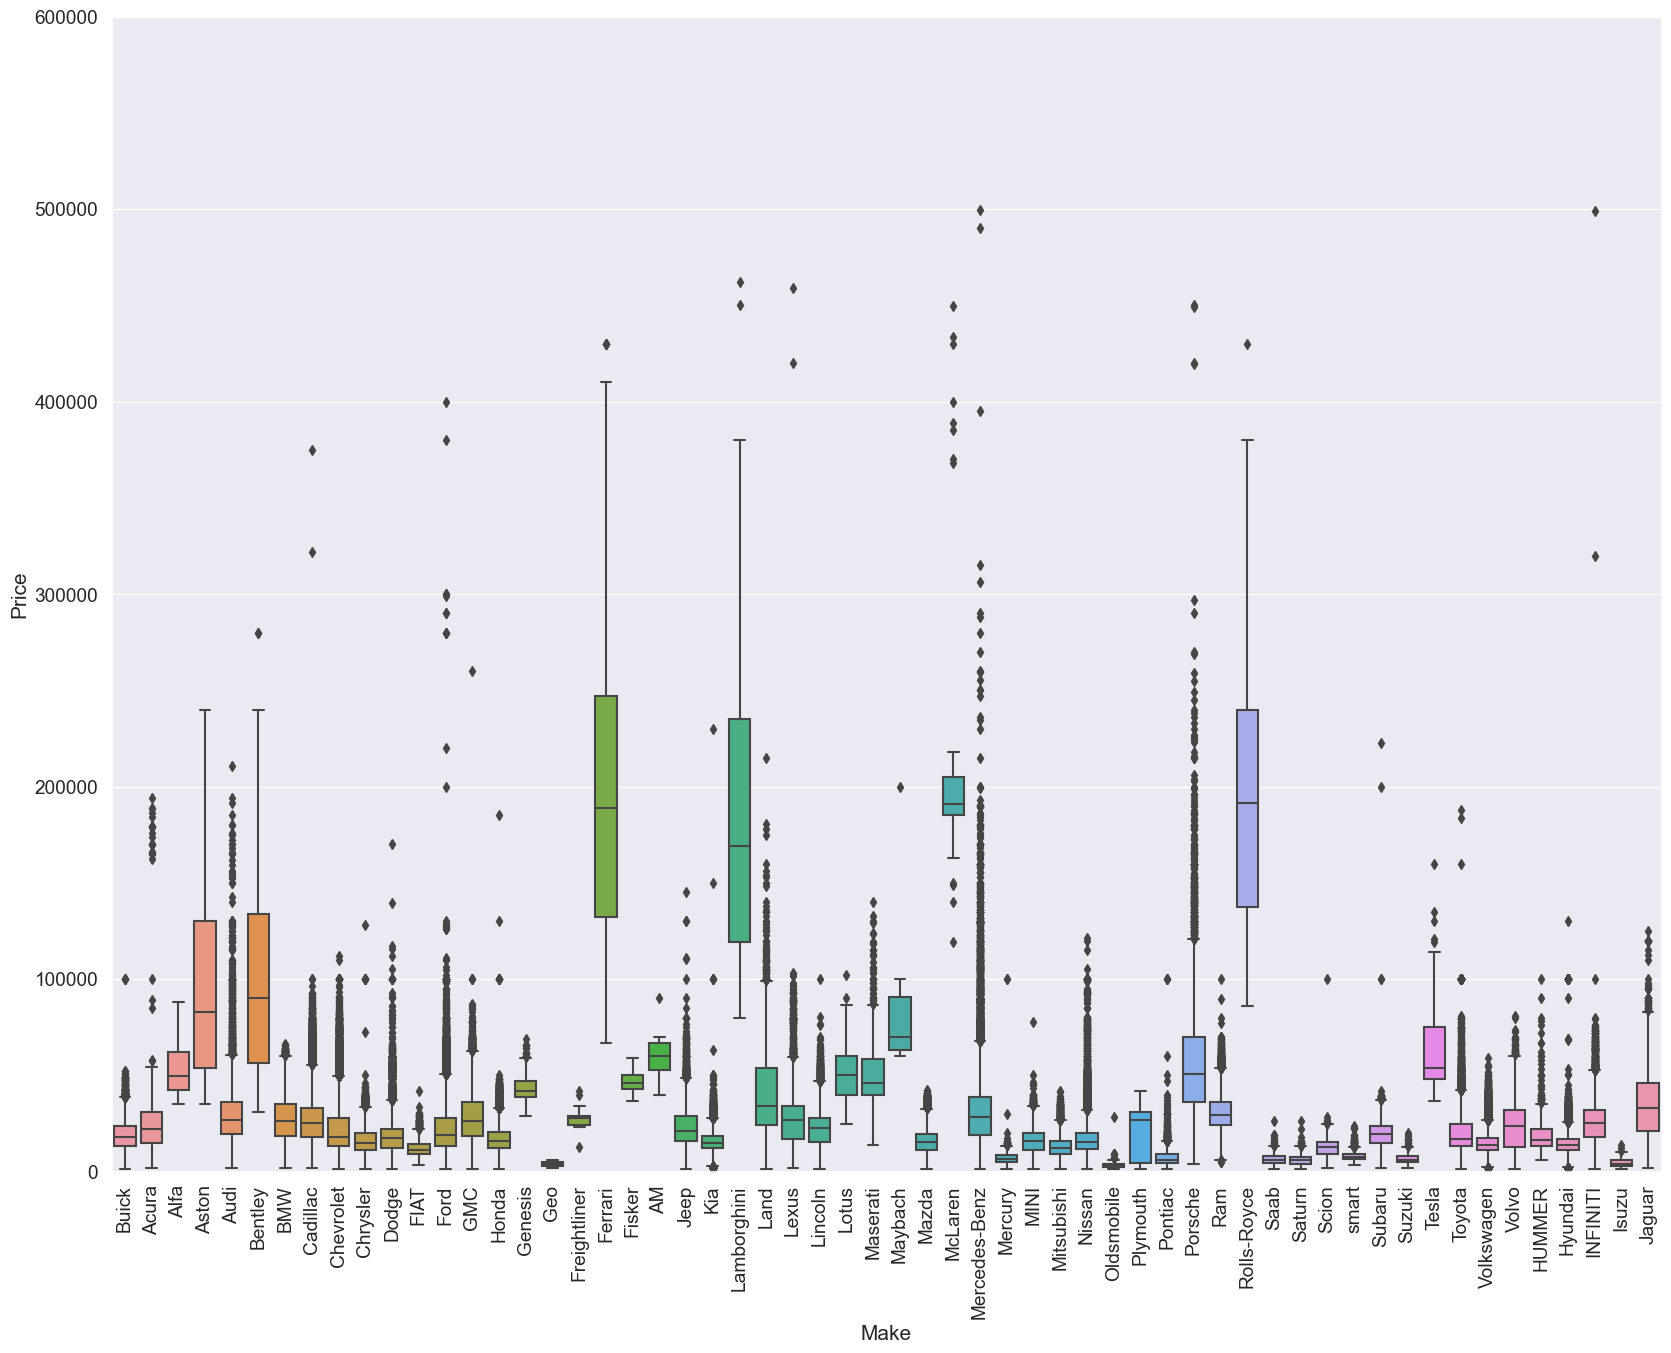

In [96]:
#Box plot showing car manufactureer /Price range

attrib= "Make"
data= pd.concat([cars["Price"], cars[attrib]], axis=1)
f, ax= plt.subplots(figsize=(20,15))
fig= sns.boxplot(x=attrib, y="Price", data= data)
fig.axis(ymin=0, ymax=600000)
plt.xticks(rotation=90);

#### We can point out the percentile values at various prices like below

In [112]:
for i in np.arange(0,1,0.1):
    print(i,": ",cars["Price"].quantile(i))

0.0 :  1500.0
0.1 :  8995.0
0.2 :  11985.0
0.30000000000000004 :  13991.0
0.4 :  15990.0
0.5 :  17995.0
0.6000000000000001 :  20599.0
0.7000000000000001 :  24000.0
0.8 :  28900.0
0.9 :  35472.0


In [123]:
from numpy import percentile
from functools import partial

category="Model"

models= cars[category].unique()

"""
Here we are taking the values between the 25th and 80th percentile of the gaussian curve.

"""


#p25= cars.groupby(by=category)[category,"Price"].agg(lambda x: percentile(x["Price"], 20))
#p80= cars.groupby(by=category)[category,"Price"].agg(lambda x: percentile(x["Price"], 80))
p20=cars.groupby(by=category)[category,"Price"].agg(lambda x: percentile(cars["Price"], 20))
p80=cars.groupby(by=category)[category,"Price"].agg(lambda x: percentile(cars["Price"], 80))


### Note the cell below

In [124]:
# # Now this strategy is applied to the 3k models; it will take up to 10 minutes
# # depending on the hardware
# models = cars[category].unique()

# cars_cleaned = pd.DataFrame()

# for i,m in enumerate(models):
#     cars_cleaned=cars_cleaned.append(cars[( (cars[category] == m ) & ( (cars["Price"] > p20.Model[m]) & (cars["Price"] <= p80.Model[m])) ) ],ignore_index=True)

     

In [125]:
cars_cleaned.to_csv("cars_outliers.csv")

### Loading cars outliers

In [5]:
cleaned_cars=pd.read_csv("cars_outliers.csv")

In [6]:
cleaned_cars.shape

(730122, 10)

In [7]:
cleaned_cars.describe()

,Unnamed: 0,Id,Price,Year,Mileage
count,730122.000000,7.301220e+05,730122.000000,730122.000000,7.301220e+05
mean,365060.500000,6.185360e+05,18838.231096,2013.965077,4.598580e+04
std,210768.210958,3.529291e+05,4611.838588,2.573777,3.282707e+04
min,0.000000,1.000000e+00,11986.000000,1997.000000,5.000000e+00
25%,182530.250000,3.209402e+05,14991.000000,2013.000000,2.416900e+04
50%,365060.500000,6.189795e+05,17995.000000,2014.000000,3.809800e+04
75%,547590.750000,9.164198e+05,22330.000000,2016.000000,6.010200e+04
max,730121.000000,1.232849e+06,28900.000000,2018.000000,2.457832e+06


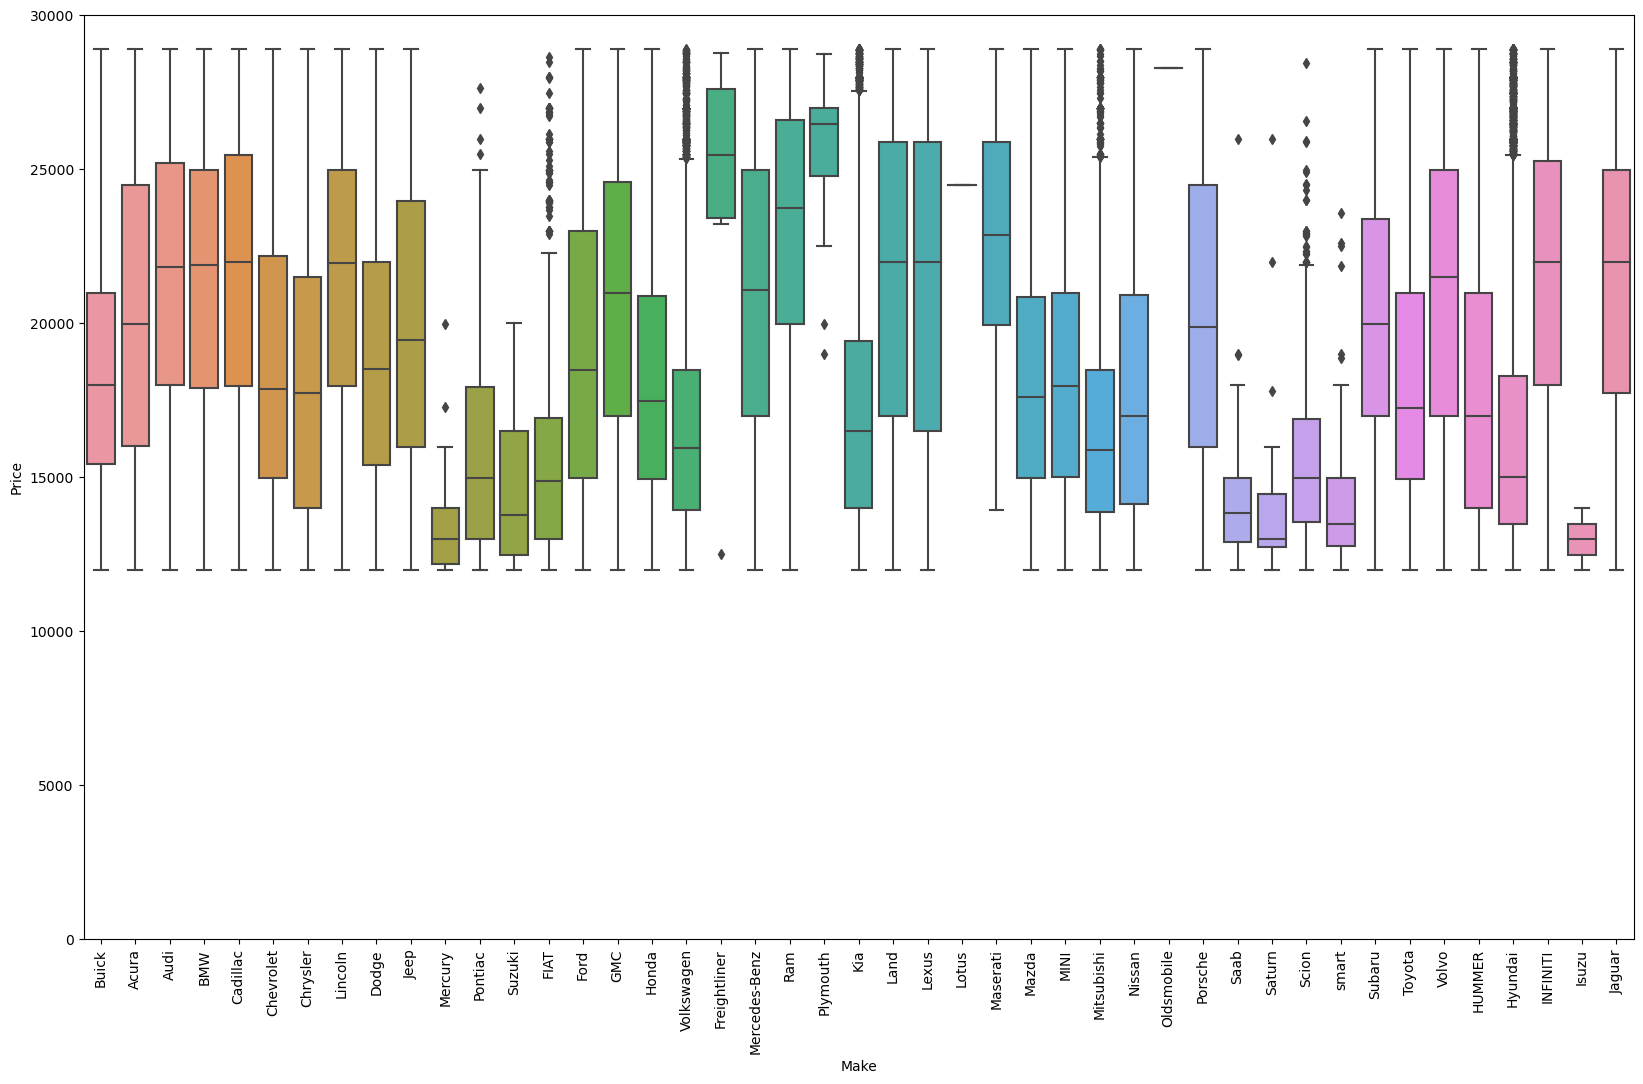

In [8]:
#Box plot showing car manufacturer / price range after cleaning 

attrib= "Make"

data= pd.concat([cleaned_cars["Price"], cleaned_cars[attrib]], axis=1)
f, ax= plt.subplots(figsize=(20,12))
fig= sns.boxplot(x= attrib, y="Price", data= data)
fig.axis(ymin=0, ymax=30000)
plt.xticks(rotation=90);



In [9]:
print("Too new: %d" % cleaned_cars.loc[cleaned_cars.Year >= 2017].count()["Id"])
print("Too few km: %d" % cleaned_cars.loc[cleaned_cars.Mileage < 5000].count()["Id"])
print("Too many km: %d" % cleaned_cars.loc[cleaned_cars.Mileage > 250000].count()["Id"])


Too new: 85336
Too few km: 21408
Too many km: 393


In [10]:
cleaned_cars.columns

Index(['Unnamed: 0', 'Id', 'Price', 'Year', 'Mileage', 'City', 'State', 'Vin',
       'Make', 'Model'],
      dtype='object')

In [11]:
#Drop some unuseful columns with respect to our analysis:

cleaned_cars= cleaned_cars.drop(["Id", "State", "Vin", "City"], axis=1)

#Replace the NaN values for categoric attributes
cleaned_cars["Make"].fillna(value="blank", inplace=True)
cleaned_cars["Make"].fillna(value="blank", inplace=True)


#Drop duplicates
cleaned_cars= cleaned_cars.drop_duplicates(["Year","Mileage", "Price","Make","Model"])

#Remove outliers
cleaned_cars = cleaned_cars[
        (cleaned_cars.Year <= 2017) 
      & (cleaned_cars.Year >= 2008)  
      & (cleaned_cars.Mileage >= 5000) 
      & (cleaned_cars.Mileage <= 250000)]

# Remove extra column
cleaned_cars = cleaned_cars.drop(["Unnamed: 0"], axis=1)
     


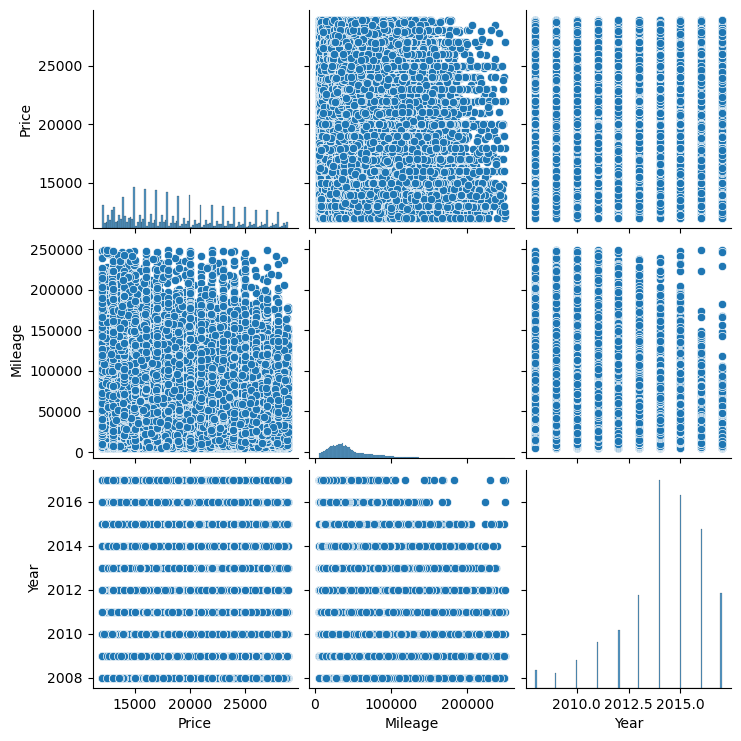

In [12]:
#Scatter plot for numerical features
num_features= ["Price", "Mileage", "Year"]
sns.pairplot(cleaned_cars[num_features], size=2.5)
plt.show()

In [13]:
cleaned_cars.sample(5)

,Price,Year,Mileage,Make,Model
53718,16400,2017,36931,Chevrolet,MalibuLT
344455,22587,2016,9783,Jeep,RenegadeLimited
39541,26987,2014,28538,Cadillac,CTS
381214,16995,2015,29920,Kia,SorentoLX
471322,12995,2015,44311,Nissan,Altima2.5


In [14]:
cleaned_cars.shape

(684164, 5)

### Towards normal distribution of prices

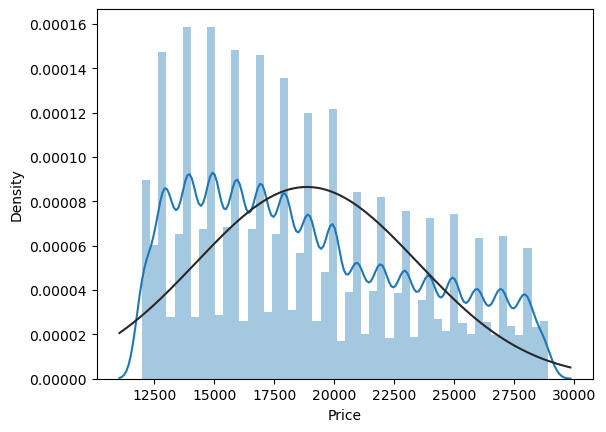

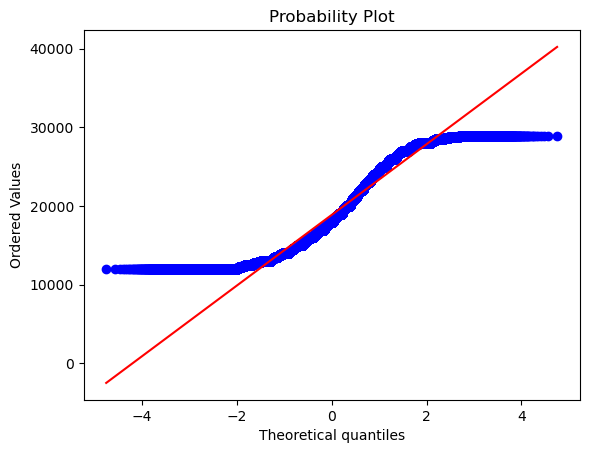

In [15]:
#Distribution of prices
from scipy.stats import norm
from scipy import stats

#Using histogram and normality plot
sns.distplot(cleaned_cars["Price"], fit= norm);
fig= plt.figure()
res= stats.probplot(cleaned_cars["Price"], plot= plt)

In [16]:
#applying log transformation
cleaned_cars["Price"]= np.log(cleaned_cars["Price"])

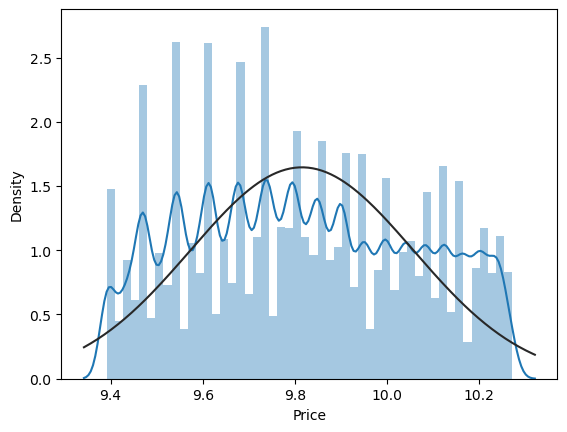

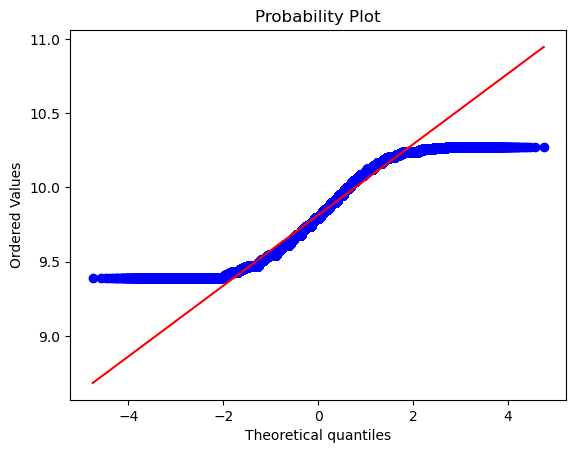

In [17]:
#transformed hidtogram and normal probability plot

sns.distplot(cleaned_cars["Price"], fit= norm)
fig= plt.figure()
res= stats.probplot(cleaned_cars["Price"], plot= plt)

### Label encoding

In [18]:
#label encoding
features= ["Make", "Model"]
les={}

for f in features:
    les[f]=preprocessing.LabelEncoder()
    les[f]= les[f].fit(cleaned_cars[f])
    cleaned_cars[f]= les[f].transform(cleaned_cars[f])

### Train test split

In [19]:
#splitting the dataset into train and test sets
train_set, test_set= train_test_split(cleaned_cars, test_size=0.33, random_state=42)

"""
The Test Set in this case is our Hold-out set that we'll be using later
for final validation
"""

# Separating target labels from the rest 
cars_train = train_set.drop("Price", axis=1) #train without target(X_train)
cars_price_train = train_set["Price"].copy() #target(y_train)

cars_test  = test_set.drop("Price", axis=1)# X_test
cars_price_test = test_set["Price"].copy()#y_test

In [20]:
cars_train.shape, cars_price_train.shape, cars_test.shape, cars_price_test.shape

((458389, 4), (458389,), (225775, 4), (225775,))

### Best score function

In [21]:
#this functions returns the best score achived by the model over all the cv splits
def best_score(forest, cv):
    best_score=0
    for i in range(0,cv):
        items= list(map(lambda x: abs(x), forest.cv_results_['split'+str(i)+'_test_score']))
        arr = np.append(best_score, items)
        best_score = max(arr)
    return best_score

### Best params function

In [22]:
# This functions returns the best combination of parameters, which allows to
# get the best score
def best_params(forest):
  return forest.cv_results_['params'][forest.cv_results_['rank_test_score'][0]-1]
     

In [23]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true (y_true) and predicted (y_predict) values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score
     

### Linear Regression

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import os

#Create a class to select numerica; pr vategorical features

class DFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_names].values

In [25]:
# Setting categorical and numerical attributes
cat_features = ["Make", "Model"]
num_features = list(cars_train.drop(cat_features, axis=1))

# Building the Pipelines for categorical and numerical dataframes
numerical_pipeline = Pipeline([
    ("selector", DFSelector(num_features)),
    ("std_scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("selector", DFSelector(cat_features)),
    ("encoder", OneHotEncoder(sparse=True, handle_unknown='ignore'))
])

# full_pipeline
full_pipeline = FeatureUnion(transformer_list =[
    ("num_pipeline", numerical_pipeline),
    ("cat_pipeline", categorical_pipeline)
])


In [26]:
#Apply the full pipeline
ohe_cars_train= full_pipeline.fit_transform(cars_train)

ohe_cars_train

<458389x1767 sparse matrix of type '<class 'numpy.float64'>'
	with 1833556 stored elements in Compressed Sparse Row format>

In [27]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()
parameters=  parameters = {'fit_intercept':[False], 'copy_X':[True, False]}

gs = GridSearchCV(estimator=model, param_grid=parameters, cv=3, n_jobs=-1, verbose=1)
lin_reg = gs.fit(ohe_cars_train, cars_price_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [28]:
bp = best_params(lin_reg)
best_params(lin_reg)

{'copy_X': True, 'fit_intercept': False}

In [29]:
lin_reg_model = LinearRegression(
                              fit_intercept=bp["fit_intercept"],
                              copy_X=bp["copy_X"])
%time lin_reg_model.fit(ohe_cars_train, cars_price_train)

CPU times: user 6min 41s, sys: 1min 33s, total: 8min 15s
Wall time: 1min 8s


LinearRegression(fit_intercept=False)

In [31]:
cars_test

,Year,Mileage,Make,Model
492423,2016,44459,28,997
541595,2016,6314,35,666
614513,2016,50693,37,1402
570685,2017,17383,37,1754
100814,2014,33136,5,1404
...,...,...,...,...
37458,2014,37372,4,269
730058,2010,119215,37,71
83927,2012,41304,5,300
419281,2015,29947,24,1005


In [33]:
ohe_cars_test = full_pipeline.transform(cars_test)

print("Best Linear Regression parameters:")
print(bp)
print("\nLinear Regressor score without CV on train set: %.3f" % lin_reg_model.score(ohe_cars_train, cars_price_train)) #score on train set
print("Linear Regression score without CV on test set: %.3f" % lin_reg_model.score(ohe_cars_test, cars_price_test)) # score on test set
print("Linear Regression Best score with CV=3: %.3f" % best_score(lin_reg, 3)) # -> best score on test set is high

Best Linear Regression parameters:
{'copy_X': True, 'fit_intercept': False}

Linear Regressor score without CV on train set: 0.784
Linear Regression score without CV on test set: 0.781
Linear Regression Best score with CV=3: 0.780


In [41]:
#Prediction on whole training set
from sklearn.metrics import mean_squared_error

price_prediction_train= lin_reg_model.predict(ohe_cars_train)

#Reversing np.log operation
price_predictions_train_normal= np.exp(price_prediction_train)
cars_price_train_normal= np.exp(cars_price_train)

#MSE between target value(ie known) and predicted values
lin_mse= mean_squared_error(cars_price_train_normal, price_predictions_train_normal)
lin_mse= np.sqrt(lin_mse)
lin_mse

2166.0854336724424

In [42]:
print(price_predictions_train_normal[580:590])
print("\n")
print(list(cars_price_train_normal[580:590]))

[27335.67305389 21634.3939238  18807.96224761 18622.13302132
 14291.21011342 16989.79963788 14680.11368475 16188.60283523
 15538.80386659 22227.16365555]


[28875.999999999978, 18895.000000000015, 19988.999999999996, 17489.000000000007, 16180.000000000013, 15896.999999999989, 15594.999999999989, 18541.000000000007, 14899.999999999995, 20998.0]


In [43]:
# Prediction on test set
price_predictions_test = lin_reg_model.predict(ohe_cars_test)

# Reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
cars_price_test_normal = np.exp(cars_price_test)

final_mse = mean_squared_error(cars_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse

2180.592492841061

In [44]:
print(price_predictions_test_normal[7650:7660]) #predictions on test set
print('\n')
print(list(cars_price_test_normal[7650:7660])) #known values in test set

[14919.4070358  18134.05939569 15827.36677245 24942.25925743
 15743.83136076 19843.4985947  24887.03983947 18110.78978721
 24324.42075617 15640.30593495]


[13198.999999999995, 17595.000000000015, 16284.000000000011, 26480.999999999978, 15230.000000000007, 17998.99999999999, 25476.999999999993, 12899.999999999993, 23777.999999999993, 16995.00000000001]


In [45]:
from sklearn.metrics import r2_score
r2_score(cars_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted') 

0.7770906291183081

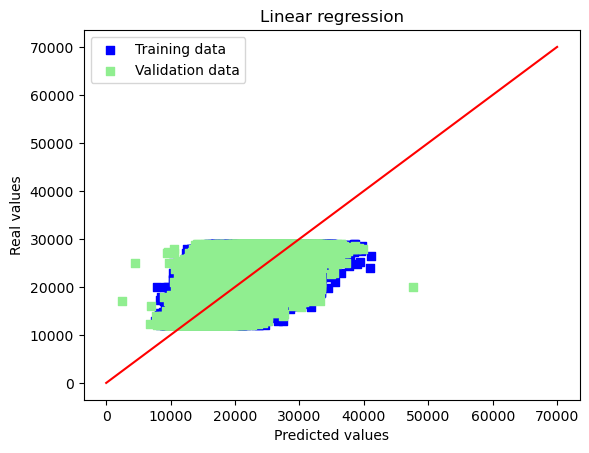

In [47]:
# Plot predictions
plt.scatter(price_predictions_train_normal, np.exp(cars_price_train), c = "blue", marker = "s", label = "Training data")
plt.scatter(price_predictions_test_normal, np.exp(cars_price_test), c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 70000], [0, 70000], c = "red")
plt.show()


In [48]:
#Saving model for type prediction
pickle.dump(lin_reg_model, open("lin_reg_model_final.pkl","wb"))

In [49]:
# Loading the model for type prediction
lin_reg_model = pickle.load(open("lin_reg_model_final.pkl", 'rb'))


### Decision Tree Regressor

In [56]:
# Import "make_scorer","DecisionTreeRegressor" and "GridSearchCV"

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

def DT_GridSearchCV(X,y):
    """
    Performs grid search over the "max_depth" parameter for a decision tree..
    regressor trained on input data [x,y]....
    """
    #Create cros validation set from the training data
    cv_sets= ShuffleSplit(n_splits= 10, test_size=0.20, random_state=42)
    
    #CReat a decision tree regressor object
    regressor= DecisionTreeRegressor()
    
    #Create a dictionary for the parameter "max_deoth" with a range from 1 to 20
    params= {'max_depth':[1,5,10,15,16,17]}
    
    #Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    tree_reg = grid.fit(X, y)
    
    # Return grid search output after fittig the data
    return tree_reg

In [57]:

from sklearn.model_selection import ShuffleSplit

# Fit the training data to the model using spark parallelized grid search CV
tree_reg = DT_GridSearchCV(cars_train, cars_price_train)

# Takign best parameters
bp = best_params(tree_reg)

# Produce the optimal value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(bp['max_depth']))

Parameter 'max_depth' is 17 for the optimal model.


In [58]:
tree_reg_model = DecisionTreeRegressor(
                              max_depth=bp['max_depth'])
%time tree_reg_model.fit(cars_train, cars_price_train)

CPU times: user 1 s, sys: 28.4 ms, total: 1.03 s
Wall time: 1.03 s


DecisionTreeRegressor(max_depth=17)

In [59]:
# DecisionTreeRegressor score for price prediction


print("Best Decision Tree Regressor parameters:")
print(bp)
print("\nDecision Tree Regressor score without CV on train set: %.3f" % tree_reg_model.score(cars_train, cars_price_train)) #score on train set
print("Decision Tree Regressor score without CV on test set: %.3f" % tree_reg_model.score(cars_test, cars_price_test)) # score on test set
print("Decision Tree Regressor Best score with CV=10: %.3f" % best_score(tree_reg, 10)) # -> best score on test set is high
     


Best Decision Tree Regressor parameters:
{'max_depth': 17}

Decision Tree Regressor score without CV on train set: 0.802
Decision Tree Regressor score without CV on test set: 0.740
Decision Tree Regressor Best score with CV=10: 0.764


In [60]:
# Prediction on whole training set
price_predictions_train = tree_reg_model.predict(cars_train) #using the whole training set for making prediction with the final model given by the best CV parameters

# Reversing np.log operation
price_predictions_train_normal = np.exp(price_predictions_train)
cars_price_train_normal = np.exp(cars_price_train)

# MSE between target values (i.e known) and predicted values
lin_mse = mean_squared_error(cars_price_train_normal, price_predictions_train_normal)
lin_rmse = np.sqrt(lin_mse)
lin_rmse # is higher than RMSE of linear regression, in fact the best score is smaller (0.58 vs 0.89)
     

2074.2505164773106

In [61]:

print(price_predictions_train_normal[1670:1680])
print('\n')
print(list(cars_price_train_normal[1670:1680]))

[22590.92541683 14819.98859597 21721.34451067 19125.03579944
 17214.62107557 23746.5172421  26785.18712544 20870.40697718
 13543.0856044  14758.58421645]


[22498.0, 14591.999999999998, 19995.00000000002, 16699.999999999996, 14911.999999999989, 23376.999999999996, 28725.000000000007, 20475.00000000001, 12994.999999999993, 14500.000000000004]


In [62]:
# Prediction on test set
price_predictions_test = tree_reg_model.predict(cars_test)

# reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
cars_price_test_normal = np.exp(cars_price_test)

final_mse = mean_squared_error(cars_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse
     

2370.0205693119956

In [63]:
print(price_predictions_test_normal[1939:1949]) #predictions on test set
print('\n')
print(list(cars_price_test_normal[1939:1949])) #known valu

[21151.14839835 16040.24675727 17213.30350312 16841.53811813
 15827.7246324  13367.14674411 22029.92630128 20671.54529735
 25943.87337204 26874.66092809]


[21987.000000000015, 12993.999999999996, 15999.00000000001, 16998.999999999996, 20994.999999999993, 14000.0, 21850.000000000004, 18887.999999999993, 25885.99999999998, 22699.000000000004]


In [64]:
from sklearn.metrics import r2_score
r2_score(cars_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted') 

0.7366801909653793

### price predixtion 

In [65]:
model = les['Model'].transform(['Maxima3.5'])
brand = les['Make'].transform(['Nissan'])

year = 2016
mileage = 21000

car = [[ year, mileage, brand[0], model[0]]]

In [66]:
predicted_price = tree_reg_model.predict(car)
print(np.exp(predicted_price))

[23880.12077655]


In [67]:
# Saving model for type prediction
pickle.dump(tree_reg_model, open("tree_reg_model_final.pkl", "wb"))

In [68]:
# Loading the model for type prediction
tree_reg_model = pickle.load(open("tree_reg_model_final.pkl", 'rb'))

## Random Forest regressor

In [72]:
# Import 'make_scorer', 'RandomForestRegressor', and 'GridSearchCV'
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

def RF_GridSearchCV(X, y):
  
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 42)

    # Create a decision tree regressor object
    regressor = RandomForestRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[16, 17, 18]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    tree_reg = grid.fit(X, y)
    
    # Return the best parameters after fitting the data
    return tree_reg

### THE CELL DOWN IS GOING TO TAKE A LONG TIME TO EXECUTE\


In [74]:
from sklearn.model_selection import ShuffleSplit

# Fit the training data to the model using spark parallelized grid search CV
forest_reg = RF_GridSearchCV(cars_train, cars_price_train)

# Takign best parameters
bp = best_params(forest_reg)

# Produce the optimal value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(bp['max_depth']))

Parameter 'max_depth' is 18 for the optimal model.


In [75]:
# Fitting the forest

forest_reg_model = RandomForestRegressor(
                              max_depth=bp['max_depth']
                                 
)

%time forest_reg_model.fit(cars_train, cars_price_train)
     

CPU times: user 1min 53s, sys: 893 ms, total: 1min 53s
Wall time: 1min 54s


RandomForestRegressor(max_depth=18)

In [76]:
# RandomForestRegressor score for price prediction

print(bp)
print("\nRandom Forest Regressor score without CV on train set: %.3f" % forest_reg_model.score(cars_train, cars_price_train)) #score on train set
print("Random Forest Regressor score without CV on test set: %.3f" % forest_reg_model.score(cars_test, cars_price_test)) #score on test set
print("Random Forest Regressor Best score with CV=4: %.3f" % best_score(forest_reg, 4)) # -> best score on test set is high

{'max_depth': 18}

Random Forest Regressor score without CV on train set: 0.855
Random Forest Regressor score without CV on test set: 0.795
Random Forest Regressor Best score with CV=4: 0.800


In [77]:
# Prediction on whole training set
price_predictions_train = forest_reg_model.predict(cars_train) #using the whole training set for making prediction with the final model given by the best CV parameters

# Reversing np.log operation
price_predictions_train_normal = np.exp(price_predictions_train)
cars_price_train_normal = np.exp(cars_price_train)

# MSE between target values (i.e known) and predicted values
lin_mse = mean_squared_error(cars_price_train_normal, price_predictions_train_normal)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

1770.1330680358076

In [78]:
print(price_predictions_train_normal[25670:25680])
print('\n')
print(list(cars_price_train_normal[25670:25680]))


[18658.77447115 18035.8762684  24860.45948196 16026.7176151
 18099.12879143 24976.49971809 14527.78180401 13791.24595465
 24629.98617803 23448.00821464]


[19900.000000000007, 16428.000000000004, 28763.00000000002, 15000.000000000004, 18994.99999999999, 28819.000000000004, 13998.999999999996, 13899.00000000001, 23678.000000000004, 23900.00000000002]


In [79]:
# Prediction on test set
price_predictions_test = forest_reg_model.predict(cars_test)

# Reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
cars_price_test_normal = np.exp(cars_price_test)

final_mse = mean_squared_error(cars_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse

2096.752608143215

In [80]:
print(price_predictions_test_normal[1870:1880]) #predictions on test set
print('\n')
print(list(cars_price_test_normal[1870:1880])) #known values in test set
     

[15264.0604462  14705.93867302 19691.72151011 17207.41981582
 20850.93341501 17520.88201273 14591.47310328 14799.83148416
 16927.31411594 20196.59582239]


[17988.000000000007, 14996.999999999996, 21499.99999999998, 17582.000000000007, 24745.000000000015, 16750.000000000004, 17679.00000000001, 12599.00000000001, 14593.000000000004, 21495.000000000015]


In [82]:
# r2 score between hold out prices and predicted prices
r2_score(cars_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted') 

0.7939020439345446

In [83]:
# Saving model for type prediction
pickle.dump(forest_reg_model, open("forest_reg_model_final.pkl", "wb"))

In [84]:
# Loading the model for type prediction
forest_reg_model = pickle.load(open("forest_reg_model_final.pkl", 'rb'))

### CROSS VALIDATION

In [85]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

#### LINEAR REGRESSION

In [86]:
#### LINEAR REGRESSION
# Cross val score on training set, although we already used GridSearchCV 

train_scores = cross_val_score(lin_reg_model, ohe_cars_train, np.exp(cars_price_train),
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-train_scores)

display_scores(tree_rmse_scores)

Scores: [2166.83832565 2172.88861604 2175.29377181 2174.12768864 2187.91840595
 2167.79109649 2173.13543574 2165.16562372 2181.87968458 2177.5069486 ]
Mean: 2174.254559721326
Standard deviation: 6.625867469700816


In [88]:
train_scores = cross_val_score(lin_reg_model, ohe_cars_train, np.exp(cars_price_train),
                          cv=10)

display_scores(train_scores)

Scores: [0.7782571  0.77804169 0.77719315 0.77758823 0.77751433 0.77808592
 0.77691906 0.77963802 0.7771837  0.77860391]
Mean: 0.7779025106692288
Standard deviation: 0.0007693612509202405


#### DECISION TREE

In [89]:
# Cross val score on training set

train_scores = cross_val_score(tree_reg_model, cars_train, np.exp(cars_price_train),
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-train_scores)

display_scores(tree_rmse_scores)
     

Scores: [2179.43495435 2432.81699112 2391.8648803  2429.8185446  2442.83219341
 2171.76563909 2423.82275761 2418.84655309 2433.80229602 2189.1986977 ]
Mean: 2351.420350730472
Standard deviation: 112.92006806413994


In [90]:
train_scores = cross_val_score(tree_reg_model, cars_train, np.exp(cars_price_train),
                          cv=10)

display_scores(train_scores)


Scores: [0.77559833 0.7218198  0.73058156 0.72213268 0.72236721 0.77711358
 0.7227081  0.72485302 0.72227304 0.77627246]
Mean: 0.7395719775661147
Standard deviation: 0.02418798771070963


#### RANDOM FOREST

### Cell below take a lot of time to execute

In [91]:
from sklearn.model_selection import KFold

# Cross val score on training set, although we already used grid search CV
train_scores = cross_val_score(forest_reg_model, cars_train, np.exp(cars_price_train),
                         scoring="neg_mean_squared_error", cv=KFold(10, shuffle=True))
forest_rmse_scores = np.sqrt(-train_scores)

display_scores(forest_rmse_scores)

Scores: [2064.12374876 2087.03955271 2096.13140046 2078.60391391 2098.76641188
 2038.60017713 2102.90530869 2108.44846372 2048.82652371 2057.38226596]
Mean: 2078.0827766927773
Standard deviation: 23.26040339442044


In [92]:
train_scores = cross_val_score(forest_reg_model, cars_train, np.exp(cars_price_train),
                          cv=5)

display_scores(train_scores)

Scores: [0.79808075 0.79777988 0.79774183 0.78884877 0.79958724]
Mean: 0.7964076921587058
Standard deviation: 0.0038394980907879473


### PREDICTIONS ON FINAL MODEL AND CONCLUSIONS

In [93]:
##